<a href="https://colab.research.google.com/github/DeanFord7/CMM307-AdvancedArtificialIntelligence/blob/main/DeanFord1702994-CMM307Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1 - Dataset

The Twitter Sentiment Analysis (TSA) dataset contains over 70,000 records of tweets related to specific entities, whether that be a compnay, a game etc. Each record has four columns, an ID for the tweet, the entity the tweet is referencing, the text conatained within the tweet and the sentiment. <br><br>
The aim of the task is to use the text of each tweet to predict and assign a sentiment classification of one of the following to the tweet:
<ul>
<li>Positive</li>
<li>Negative</li>
<li>Neutral</li>
<li>Irrelevant</li>
</ul>

In the dataset, 'Neutral' and 'Irrelevant' are seperate labels for the sentiment classification but both are considered to be the same result.

In [24]:
import kagglehub
import os

# Load dataset from kagglehub
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in directory:", files)

Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2
Files in directory: ['twitter_validation.csv', 'twitter_training.csv']


In [25]:
import pandas as pd

# Dataset is already split into a training and testing file so retrieve both
training_file_path = os.path.join(path, "twitter_training.csv")
validation_file_path = os.path.join(path, "twitter_validation.csv")

# Set column names for dataframe
column_names = ["tweet_id", "entity", "sentiment", "tweet_text"]

# Load datasets into dataframes
training_df = pd.read_csv(training_file_path, names=column_names)
validation_df = pd.read_csv(validation_file_path, names=column_names)

#print(training_df.head())
print("Train", len(training_df))
print("Val", len(validation_df))
#print(validation_df.head())

# Combine the dataframes as the pre made validation set has only 1,000 values compared to the testing sets 69,000
sentiment_df = pd.concat([training_df, validation_df], ignore_index=True)

print("Combined Dataframe:")
print(sentiment_df.head())
print("Records: ", len(sentiment_df))

# The dataset contains 6 records for each tweet with the first being the original and the next 5 being slight alterations of the text
# Remove the additional records for each tweet as the original text in the most relevant and the duplicates only have minor grammatical changes
filtered_sentiment_df = sentiment_df.drop_duplicates(subset=["tweet_id"], keep="first")

# Remove NaN values
filtered_sentiment_df = filtered_sentiment_df[filtered_sentiment_df['tweet_text'].notnull()]
# Remove empty strings
filtered_sentiment_df = filtered_sentiment_df[filtered_sentiment_df['tweet_text'].str.strip() != '']

# Change sentiment values from 'Irrelevant' to 'Neutral'
# 'Irrelevant' and 'Neutral' are treated as the same result in the dataset so convert all to 'Neutral' to avoid confusion in the results
filtered_sentiment_df.loc[filtered_sentiment_df['sentiment'] == 'Irrelevant', 'sentiment'] = 'Neutral'

print("Filtered Dataframe:")
print(filtered_sentiment_df.head())
print("Records: ", len(filtered_sentiment_df))


Train 74682
Val 1000
Combined Dataframe:
   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                          tweet_text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
Records:  75682
Filtered Dataframe:
    tweet_id       entity sentiment  \
0       2401  Borderlands  Positive   
6       2402  Borderlands  Positive   
12      2403  Borderlands   Neutral   
18      2404  Borderlands  Positive   
24      2405  Borderlands  Negative   

                                           tweet_text  
0   im getting on borderlands and i will murder yo...  
6   So I spent a 

In [26]:
tweets = list(filtered_sentiment_df['tweet_text'])
sentiments = list(filtered_sentiment_df['sentiment'])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Convert the sentiment strings into numerical values
sentiments_numerical = label_encoder.fit_transform(sentiments)



In [27]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def prep(sentences):
  prep_text = []

  words = stopwords.words('english')
  entity_labels = list(filtered_sentiment_df['entity'])
  words.extend(entity_labels)

  for sent in sentences:
    token_text = word_tokenize(sent)
    normalised_text = [token.lower() for token in token_text if token.isalpha()]

    swr_text = [token for token in normalised_text if token not in words]

    prep_text += [[lemmatizer.lemmatize(word) for word in swr_text]]
  prep_sentences = [" ".join(sentence) for sentence in prep_text]
  return prep_sentences



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Section 2 - Representation Learning

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_base = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Section 3 -  Algorithms

In [29]:
import tensorflow
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score

## Multi-Layer Perceptron

A Multi_Layer Perceptron (MLP) is a type of Artificial Neural Network, made up of different layers of interconnected nodes. The 3 layers typically featured in an MLP are the input layer, which takes in a numerical vector whos size will then determine the size of the input layer, the hidden layer, which is connected to both the input and output layers and can be repated one or more times, and the ouput layer

In [30]:
def mlp(dataset_size, num_classes):
  input_shape = (dataset_size,)

  model = Sequential()
  model.add(Dense(128, input_shape=input_shape, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

kf = StratifiedKFold(n_splits=5, shuffle=True)
xnp = np.array(tweets)
ynp = np.array(sentiments_numerical)

mlp_accuracy_score = []
mlp_f1_score = []

for train, test in kf.split(xnp,ynp):
  x_train, x_test, y_train, y_test = xnp[train], xnp[test], ynp[train], ynp[test]

  x_train = prep(x_train)
  x_test = prep(x_test)

  tfidf = tfidf_base
  x_train = tfidf.fit_transform(x_train)
  x_train = x_train.todense()
  x_test = tfidf.transform(x_test)
  x_test = x_test.todense()
  num_classes = len(np.unique(y_train))
  model = mlp(1000, num_classes)
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)

  # Code taken and adapted from https://keras.io/api/callbacks/early_stopping/
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2, callbacks=[early_stopping])

  test_results = model.evaluate(x_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

  mlp_accuracy_score.append(test_results[1])
  # Code taken and adapted from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
  mlp_predictions = model.predict(x_test)
  mlp_predictions = np.argmax(mlp_predictions, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)
  mlp_f1 = f1_score(mlp_predictions, y_test_labels, average='weighted')
  mlp_f1_score.append(mlp_f1)

print("MLP Accuracy:", np.mean(mlp_accuracy_score) * 100, "%")
print("MLP F1 Score:", np.mean(mlp_f1_score))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4158 - loss: 1.0795 - val_accuracy: 0.3971 - val_loss: 1.0583
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4933 - loss: 0.9706 - val_accuracy: 0.5657 - val_loss: 0.9138
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6590 - loss: 0.7700 - val_accuracy: 0.5723 - val_loss: 0.9272
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7021 - loss: 0.6925 - val_accuracy: 0.5708 - val_loss: 0.9567
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7446 - loss: 0.6307 - val_accuracy: 0.5631 - val_loss: 1.0161
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7643 - loss: 0.5760 - val_accuracy: 0.5596 - val_loss: 1.0559
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8002 - loss: 0.5175 - val_accuracy: 0.5642 - val_loss: 1.1318
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6002 - loss: 0.8670
Test results - Loss: 0.8652858734130859 - Accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3769 - loss: 1.0840 - val_accuracy: 0.4073 - val_loss: 1.0534
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4992 - loss: 0.9740 - val_accuracy: 0.5876 - val_loss: 0.9028
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6699 - loss: 0.7644 - val_accuracy: 0.5789 - val_loss: 0.8912
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7149 - loss: 0.6806 - val_accuracy: 0.5743 - val_loss: 0.9410
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7392 - loss: 0.6279 - val_accuracy: 0.5687 - val_loss: 0.9847
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7657 - loss: 0.5864 - val_accuracy: 0.5662 - val_loss: 1.0190
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7872 - loss: 0.5341 - val_accuracy: 0.5626 - val_loss: 1.1039
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8240 - loss: 0.4723 - val_accuracy: 0.5545 - val_loss: 1.2153
7

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3775 - loss: 1.0867 - val_accuracy: 0.3931 - val_loss: 1.0617
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4714 - loss: 0.9906 - val_accuracy: 0.5698 - val_loss: 0.9095
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6633 - loss: 0.7852 - val_accuracy: 0.5713 - val_loss: 0.9129
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7034 - loss: 0.6917 - val_accuracy: 0.5810 - val_loss: 0.9335
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7349 - loss: 0.6448 - val_accuracy: 0.5631 - val_loss: 0.9854
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7490 - loss: 0.6191 - val_accuracy: 0.5555 - val_loss: 1.0925
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7874 - loss: 0.5498 - val_accuracy: 0.5519 - val_loss: 1.1329
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5843 - loss: 0.8884
Test results - Loss: 0.8881569504737854 - Accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4078 - loss: 1.0804 - val_accuracy: 0.3941 - val_loss: 1.0529
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4983 - loss: 0.9626 - val_accuracy: 0.5692 - val_loss: 0.8929
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6746 - loss: 0.7547 - val_accuracy: 0.5626 - val_loss: 0.8967
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7100 - loss: 0.6721 - val_accuracy: 0.5550 - val_loss: 0.9330
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7439 - loss: 0.6206 - val_accuracy: 0.5336 - val_loss: 0.9895
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7538 - loss: 0.5905 - val_accuracy: 0.5229 - val_loss: 1.0827
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7978 - loss: 0.5163 - val_accuracy: 0.5148 - val_loss: 1.1192
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5827 - loss: 0.8683
Test results - Loss: 0.878589928150177 - Accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4087 - loss: 1.0769 - val_accuracy: 0.4099 - val_loss: 1.0408
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5230 - loss: 0.9462 - val_accuracy: 0.5738 - val_loss: 0.9058
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6699 - loss: 0.7545 - val_accuracy: 0.5723 - val_loss: 0.9264
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7052 - loss: 0.6778 - val_accuracy: 0.5677 - val_loss: 0.9716
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7357 - loss: 0.6181 - val_accuracy: 0.5698 - val_loss: 1.0236
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7705 - loss: 0.5695 - val_accuracy: 0.5611 - val_loss: 1.1059
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7982 - loss: 0.5236 - val_accuracy: 0.5524 - val_loss: 1.1887
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5886 - loss: 0.8798
Test results - Loss: 0.8728625774383545 - Accuracy: 0.

## k-Nearest Neighbour

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

kf = StratifiedKFold(n_splits=5, shuffle=True)

xnp = np.array(tweets)
ynp = np.array(sentiments_numerical)

knn_accuracy_score = []
knn_f1_score = []

for train, test in kf.split(xnp,ynp):

  x_train, x_test, y_train, y_test = xnp[train], xnp[test], ynp[train], ynp[test]

  x_train = prep(x_train)
  x_test = prep(x_test)

  tfidf = tfidf_base
  x_train = tfidf.fit_transform(x_train)
  x_train = np.asarray(x_train.todense())
  x_test = tfidf.transform(x_test)
  x_test = np.asarray(x_test.todense())
  param_grid = {
        'n_neighbors': [1, 3, 5, 7]
    }

  grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
  grid_search.fit(x_train, y_train)

  best_kNN = grid_search.best_estimator_

  knn_predictions = best_kNN.predict(x_test)
  knn_acc = accuracy_score(knn_predictions, y_test)
  knn_accuracy_score.append(knn_acc)

  knn_f1 = f1_score(knn_predictions, y_test, average='weighted')
  knn_f1_score.append(knn_f1)

print("kNN Accuracy:", np.mean(knn_accuracy_score) * 100, "%")
print("kNN F1 Score:", np.mean(knn_f1_score))

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


kNN Accuracy: 4852.138492871691 %
kNN F1 Score: 0.5216031220163252


## Naive Bayes

In [32]:
# Code taken and adapted from https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

from sklearn import naive_bayes

nb_accuracy_scores = []
nb_f1_scores = []

Encoder = LabelEncoder()
ynp_encoded = Encoder.fit_transform(ynp)  # Encoding target labels

for train_idx, test_idx in kf.split(xnp, ynp_encoded):
    x_train, x_test = np.array(tweets)[train_idx], np.array(tweets)[test_idx]
    y_train, y_test = ynp_encoded[train_idx], ynp_encoded[test_idx]

    x_train = prep(x_train)
    x_test = prep(x_test)

    tfidf = tfidf_base
    x_train = tfidf.fit_transform(x_train)
    x_train = np.asarray(x_train.todense())
    x_test = tfidf.transform(x_test)
    x_test = np.asarray(x_test.todense())

    naive = naive_bayes.MultinomialNB()
    naive.fit(x_train, y_train)

    nb_predictions = naive.predict(x_test)

    accuracy = accuracy_score(y_test, nb_predictions)
    nb_accuracy_scores.append(accuracy)

    nb_f1 = f1_score(y_test, nb_predictions, average='weighted')
    nb_f1_scores.append(nb_f1)

print(f"Naive Bayes Accuracy:", np.mean(nb_accuracy_scores) * 100, "%")
print(f"Naive Bayes F1 Score:", np.mean(nb_f1_scores))

Naive Bayes Accuracy: 59.9348268839104 %
Naive Bayes F1 Score: 0.5962953555119096


# Section 4 - Evaluation

[0.6016293168067932, 0.5926679968833923, 0.5890020132064819, 0.5816700458526611, 0.5951120257377625]
[49.08350305498982, 49.246435845213846, 47.41344195519348, 49.16496945010183, 47.69857433808554]


[Text(1, 0, 'knn'), Text(2, 0, 'mlp'), Text(3, 0, 'nb')]

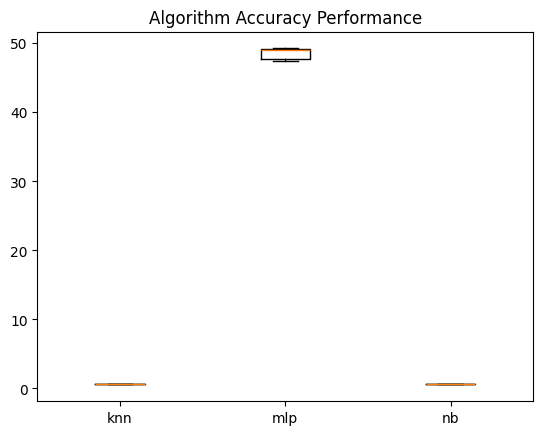

In [33]:
import matplotlib as plt

model_accuracy_comp = []
model_accuracy_comp.append(mlp_accuracy_score)
print(mlp_accuracy_score)
model_accuracy_comp.append(knn_accuracy_score)
print(knn_accuracy_score)
model_accuracy_comp.append(nb_accuracy_scores)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Accuracy Performance')
ax2.boxplot(model_accuracy_comp)
ax2.set_xticklabels(['knn', 'mlp', 'nb'])

[Text(1, 0, 'knn'), Text(2, 0, 'mlp'), Text(3, 0, 'nb')]

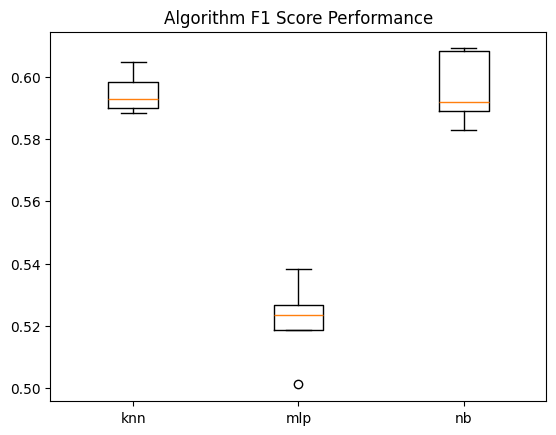

In [34]:
import matplotlib as plt

model_f1_comp = []
model_f1_comp.append(mlp_f1_score)
model_f1_comp.append(knn_f1_score)
model_f1_comp.append(nb_f1_scores)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm F1 Score Performance')
ax2.boxplot(model_f1_comp)
ax2.set_xticklabels(['knn', 'mlp', 'nb'])

# Section 5 - Paper Overview

https://www.researchgate.net/publication/352780855_Twitter_Sentiment_Analysis_using_Deep_Learning

The chosen paper aims to explore the effectiveness of different machine learning algorithms in correctly predicting the sentiment classification of a dataset of tweets. The classification is treated as a binary classification problem with the only available sentiment labels being 'Positive' and 'Negative. <br>
The paper employs a number of pre-processing techniques specific to the problem of analysing tweets, such as replacing hashtagged words with just the text of the hashtag and shortening words where the same letter appears more than twice in sequence. <br>
The paper then trains 10 different models commonly used for text classification, with particular focus on the implementation of multiple configurations of both Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN). <br>
Once each model had been trained, an ensemble model was created using some of the best performing models. The ensemble model took a majority vote of predictions from 5 models chosen from the most succesful configurations of the CNN and RNN models trained.

# Section 6 - Paper Algorithms

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer

In [36]:
vocab_size = 20000
random_embedding_dimension = 32
glove_embedding_dimension = 200
max_length = 40
lstm_units_random = 100
lstm_units_glove = 128
dense_units_random = 32
dense_units_glove = 64

In [37]:
# The paper only considers positive and negative sentiments for the algorithm
# Because of this we filter the dataset to only include these rows for use in the models
binary_sentiment_df = filtered_sentiment_df.drop(filtered_sentiment_df[filtered_sentiment_df['sentiment'] == 'Neutral'].index)

binary_tweets = list(binary_sentiment_df['tweet_text'])
# Pre-process the tweets
binary_tweets = prep(binary_tweets)
binary_sentiments = list(binary_sentiment_df['sentiment'])

# Convert the sentiments to numerical values
label_encoder = LabelEncoder()
binary_sentiments_numerical = label_encoder.fit_transform(binary_sentiments)

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(binary_tweets)

# Convert the tweets into sequneces and pad them to fit the max length of 40
sequences = tokenizer.texts_to_sequences(binary_tweets)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

binary_xnp = np.array(padded_sequences)
binary_ynp = np.array(binary_sentiments_numerical)

In [39]:
# Code taken and adapted from:
# https://stackoverflow.com/questions/35089956/how-to-use-the-embedding-layer-for-recurrent-neural-network-rnn-in-keras
# https://keras.io/api/layers/core_layers/embedding/
# https://keras.io/api/layers/regularization_layers/dropout/
# https://keras.io/api/layers/recurrent_layers/lstm/

# Add the layers to the random embedding model
random_embedding_model = Sequential()
random_embedding_model.add(Embedding(input_dim=vocab_size, output_dim=random_embedding_dimension, input_length=max_length))
random_embedding_model.add(Dropout(0.2))
random_embedding_model.add(LSTM(lstm_units_random))
random_embedding_model.add(Dense(dense_units_random, activation='relu'))
random_embedding_model.add(Dropout(0.2))
random_embedding_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(binary_xnp, binary_ynp, test_size=0.2, random_state=42)

random_embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Paper makes no mention of how many epochs were run
# Through testing it was found the first epoch recorded the highets accuracy with a large drop off before recovering to a value lower than the first
history = random_embedding_model.fit(x_train, y_train, epochs=8, batch_size=32, validation_split=0.2)

random_loss, random_accuracy = random_embedding_model.evaluate(x_test, y_test)
print(f"Random Embedding Model Loss: {random_loss}")
print(f"Random Embedding Model Accuracy: {random_accuracy}")

Epoch 1/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4892 - loss: 0.6938 - val_accuracy: 0.5411 - val_loss: 0.6910
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5104 - loss: 0.6936 - val_accuracy: 0.5411 - val_loss: 0.6917
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5927 - loss: 0.6723 - val_accuracy: 0.6364 - val_loss: 0.6422
Epoch 4/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6448 - loss: 0.6198 - val_accuracy: 0.6547 - val_loss: 0.6268
Epoch 5/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6577 - loss: 0.6069 - val_accuracy: 0.6967 - val_loss: 0.6715
Epoch 6/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7471 - loss: 0.5788 - val_accuracy: 0.6897 - val_loss: 0.6151
Epoch 7/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7763 - loss: 0.5317 - val_accuracy: 0.6993 - val_loss: 0.6252
Epoch 8/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8036 - loss: 0.4972 - val_accuracy:

In [41]:
# Download GloVe embeddings from stanford
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d /content/glove_data

# Set the path to the GloVe file to be used
glove_file_path = '/content/glove_data/glove.6B.200d.txt'

--2024-12-04 16:27:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-04 16:27:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-04 16:27:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [42]:
# Code taken and adapted from https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

glove_embeddings_index = {}

# Create the GloVe matrix from the txt file
with open(glove_file_path, 'r', encoding='utf-8') as f:
  for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings_index[word] = vector

glove_matrix = np.zeros((vocab_size, glove_embedding_dimension))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            glove_matrix[index] = embedding_vector

# Add the layers to the GloVe embedding model
glove_embedding_model = Sequential()
glove_embedding_model.add(Embedding(input_dim=vocab_size, output_dim=glove_embedding_dimension, input_length=max_length, weights=[glove_matrix], trainable=True))
glove_embedding_model.add(Dropout(0.4))
glove_embedding_model.add(LSTM(lstm_units_glove))
glove_embedding_model.add(Dense(dense_units_glove, activation='relu'))
glove_embedding_model.add(Dropout(0.5))
glove_embedding_model.add(Dense(1, activation='sigmoid'))

In [43]:
x_train, x_test, y_train, y_test = train_test_split(binary_xnp, binary_ynp, test_size=0.2, random_state=42)

glove_embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Paper makes no mention of how many epochs were run
# Through testing it was found the highest accuracy came on the first epoch with a large drop off until epoch 6 which would significantly lower the average
history = glove_embedding_model.fit(x_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

glove_loss, glove_accuracy = glove_embedding_model.evaluate(x_test, y_test)
print(f"GloVe Embedding Model Loss: {glove_loss}")
print(f"GloVe Embedding Model Accuracy: {glove_accuracy}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.5549 - loss: 0.6810 - val_accuracy: 0.7561 - val_loss: 0.5633
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7691 - loss: 0.5628
GloVe Embedding Model Loss: 0.5666301846504211
GloVe Embedding Model Accuracy: 0.7615384459495544


# Section 7 - Paper Evaluation

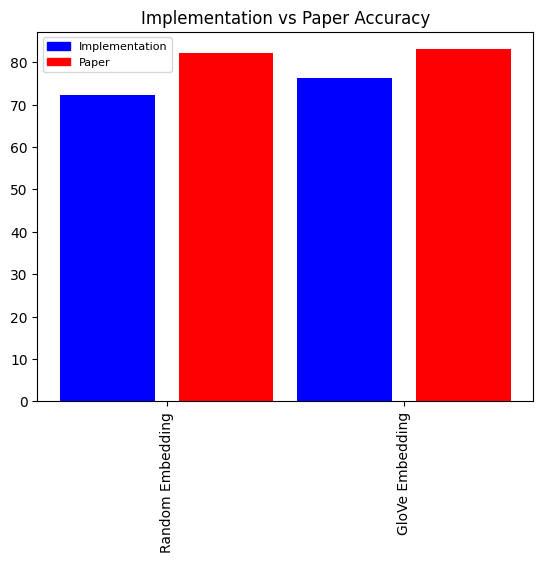

In [60]:
import matplotlib.patches as mpatches

# Best results from the paper for the Random and GloVe Embedding Models
paper_random_accuracy = 82.2
paper_glove_accuracy = 83.0

model_comp = []
model_comp.append(random_accuracy * 100)
model_comp.append(paper_random_accuracy)
model_comp.append(glove_accuracy * 100)
model_comp.append(paper_glove_accuracy)

fig, ax2 = plt.pyplot.subplots()

ax2.set_title('Implementation vs Paper Accuracy')
x_positions = range(len(model_comp))
ax2.bar(x_positions, model_comp, color=['blue', 'red', 'blue', 'red'])
ax2.set_xticks([0.5, 2.5])
ax2.set_xticklabels(['Random Embedding', 'GloVe Embedding'], rotation='vertical')

blue_patch = mpatches.Patch(color='blue', label='Implementation')
red_patch = mpatches.Patch(color='red', label='Paper')

ax2.legend(handles=[blue_patch, red_patch], loc="best", fontsize=8, markerscale=0.8)
